<a href="https://colab.research.google.com/github/afaqahmed91/deeplearning/blob/main/notebooks/indoor_temperature_predictor/Timeseries_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Alcohol_Sales.csv to Alcohol_Sales.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("Alcohol_Sales.csv", index_col = "DATE", parse_dates = True)
df.index.freq = "MS"

In [3]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


<Axes: xlabel='DATE'>

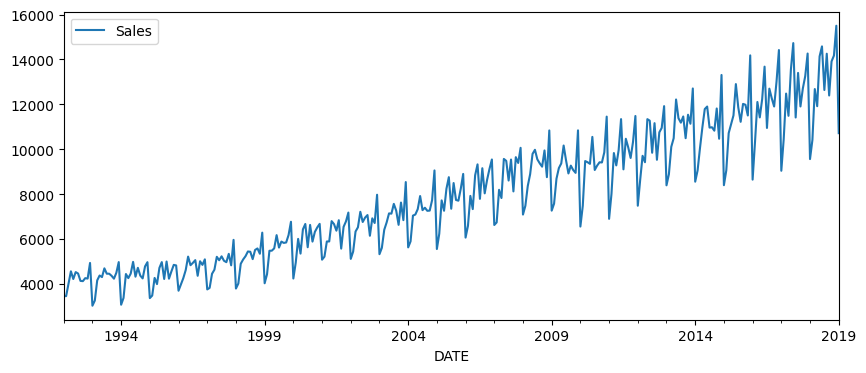

In [4]:
df.columns = ["Sales"]
df.plot(figsize = (10,4))

In [5]:
!pip install statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose

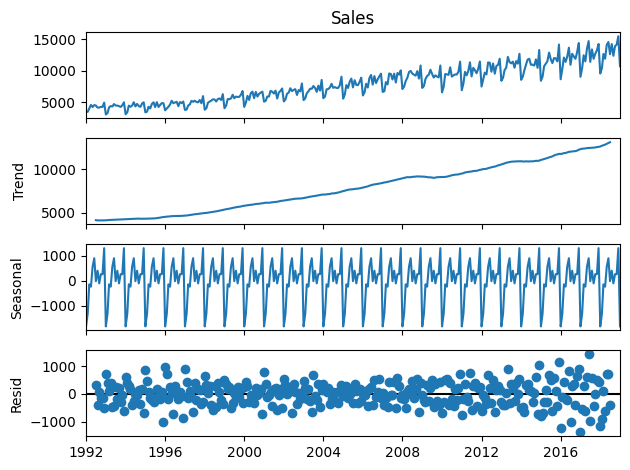

In [6]:
results = seasonal_decompose(df["Sales"])
results.plot();

<Axes: xlabel='DATE'>

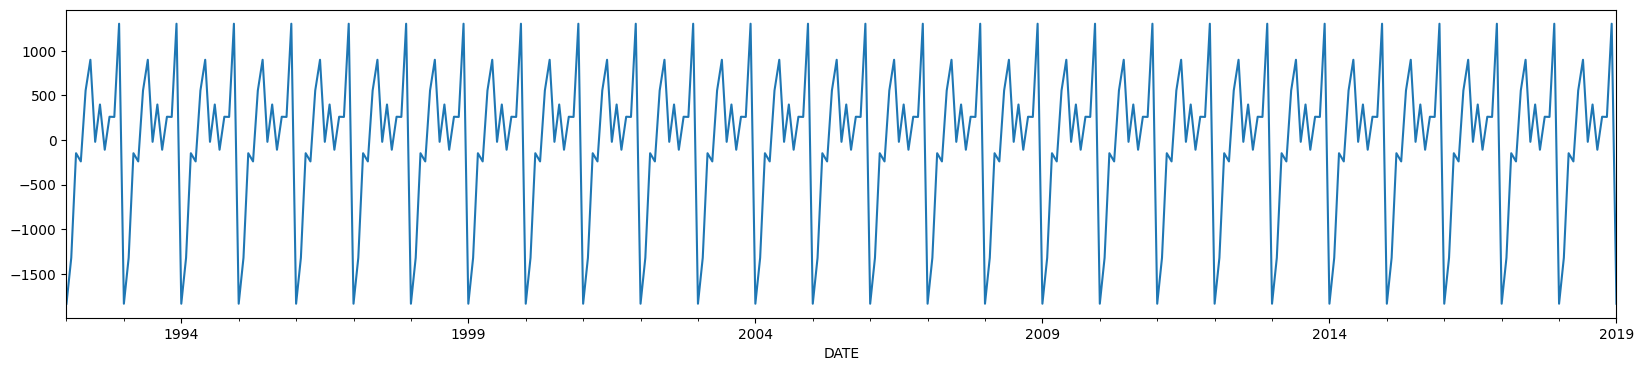

In [7]:
results.seasonal.plot(figsize = (20,4))

In [8]:
df.head()

,Sales
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


In [9]:
train = df.iloc[:313]
test = df.iloc[313:]

In [10]:
# You need to scale the data

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train) # always fit to the test data as you will not know the data in the future

MinMaxScaler()

In [12]:
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test) # use the same scalar to fit the test as well

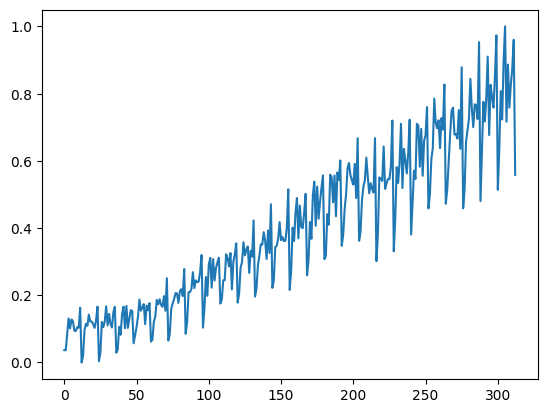

In [13]:
plt.plot(scaled_train)

LSTM need a set of lagged values and the actual current value to predict
`[t-1, t-2, t-3] , [t]`

In [14]:
import tensorflow as tf

In [15]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [40]:
n_inputs = 12 # training sequence (you should take into account for the seasonality)
n_features = 1 # columns of data
generator = TimeseriesGenerator(data = scaled_train, targets = scaled_train,length =n_inputs, batch_size = 1)

In [46]:
generator[0]

(array([[[0.03658432],
         [0.03649885],
         [0.08299855],
         [0.13103684],
         [0.1017181 ],
         [0.12804513],
         [0.12266006],
         [0.09453799],
         [0.09359774],
         [0.10496624],
         [0.10334217],
         [0.16283443]]]),
 array([[0.]]))

In [45]:
scaled_train[:13]

array([[0.03658432],
       [0.03649885],
       [0.08299855],
       [0.13103684],
       [0.1017181 ],
       [0.12804513],
       [0.12266006],
       [0.09453799],
       [0.09359774],
       [0.10496624],
       [0.10334217],
       [0.16283443],
       [0.        ]])

<img src="https://www.researchgate.net/profile/Savvas_Varsamopoulos/publication/329362532/figure/download/fig5/AS:699592479870977@1543807253596/Structure-of-the-LSTM-cell-and-equations-that-describe-the-gates-of-an-LSTM-cell.jpg" alt="Drawing"/>

In [136]:
### Defining the RNN Model structure ###
def build_model(rnn_units, n_input, n_features):
  model = tf.keras.Sequential([

    # Layer 1: LSTM with `rnn_units` number of units.
    # TODO: Call the LSTM function defined above to add this layer.
    tf.keras.layers.LSTM(
    rnn_units,
    activation='relu', # (default = tanh) final activation is tanh
    recurrent_initializer='glorot_uniform', # default
    recurrent_activation='sigmoid', # (default) internal activation is signmoid
    input_shape=(n_input, n_features),
    ),

    # Layer 2: Dense (fully-connected) layer that transforms the LSTM output
    #   into the vocabulary size.
    # TODO: Add the Dense layer.
    tf.keras.layers.Dense(1)
  ])

  return model


In [137]:
model = build_model(300, n_inputs, n_features)

In [138]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 300)               362400    
                                                                 
 dense_4 (Dense)             (None, 1)                 301       
                                                                 
Total params: 362701 (1.38 MB)
Trainable params: 362701 (1.38 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [139]:
# test Model
x = generator[0][0]
y = generator[0][1]
test_pred = model(x)
test_pred.numpy()

array([[-0.00181973]], dtype=float32)

In [140]:
### Defining the loss function ###
def compute_loss(labels, logits):
  loss = tf.keras.losses.MeanSquaredError()
  return loss(labels,logits)

In [141]:
# test loss

example_batch_loss = compute_loss(y, test_pred) # TODO
print("scalar_loss:      ", example_batch_loss.numpy().mean())

scalar_loss:       3.3114052e-06


In [142]:
### Defining the Optimezer ###
'''Checkout the tensorflow website for a list of supported optimizers.
  https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/
  Try using the Adam optimizer to start.'''
optimizer = tf.keras.optimizers.Adam(
    learning_rate = 0.0005, # default
    )


In [143]:
### Define training operation ###

@tf.function
def train_step(x, y):
  # Use tf.GradientTape()
  with tf.GradientTape() as tape:

    '''feed the current input into the model and generate predictions'''
    y_hat = model(x)

    '''compute the loss!'''
    loss = compute_loss(y, y_hat)

  # Now, compute the gradients
  '''complete the function call for gradient computation.
      Remember that we want the gradient of the loss with respect all
      of the model parameters.'''
  grads = tape.gradient(loss, model.trainable_variables)

  # Apply the gradients to the optimizer so it can update the model accordingly
  optimizer.apply_gradients(zip(grads, model.trainable_variables))
  return loss

In [144]:

##################
# Begin training!#
##################

history = {}

for epoch in range(0, 20):
  history[epoch] = []
  for i in range(0,generator.__len__()):
    loss = train_step(generator[i][0],generator[i][1] )
    # Print the loss
    loss_val = loss.numpy().mean()
    history[epoch].append(loss_val)
  print(f'Epoch {epoch + 1}, Loss: {np.mean(history[epoch])}')


Epoch 1, Loss: 0.007670204620808363
Epoch 2, Loss: 0.005256530828773975
Epoch 3, Loss: 0.0035869861021637917
Epoch 4, Loss: 0.003270696848630905
Epoch 5, Loss: 0.002865782706066966
Epoch 6, Loss: 0.0026056552305817604
Epoch 7, Loss: 0.0022844155319035053
Epoch 8, Loss: 0.002057021949440241
Epoch 9, Loss: 0.0019056197488680482
Epoch 10, Loss: 0.0017777910688892007
Epoch 11, Loss: 0.0016812916146591306
Epoch 12, Loss: 0.0016024434007704258
Epoch 13, Loss: 0.001526948413811624
Epoch 14, Loss: 0.0014706437941640615
Epoch 15, Loss: 0.0014330986887216568
Epoch 16, Loss: 0.0014045670395717025
Epoch 17, Loss: 0.0013941425131633878
Epoch 18, Loss: 0.0013768597273156047
Epoch 19, Loss: 0.001357045373879373
Epoch 20, Loss: 0.0013695515226572752


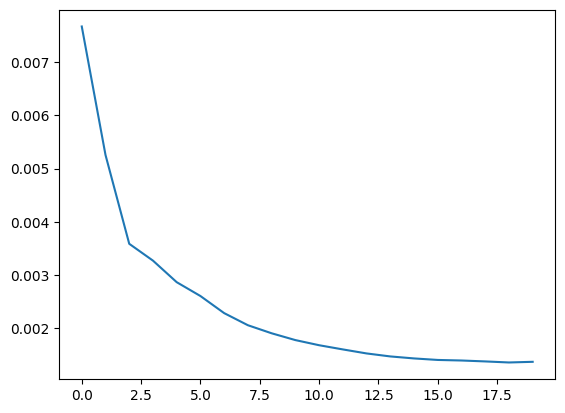

In [145]:
plt.plot(history.keys(), [np.mean(val)  for val in history.values()])

In [146]:
input_eval = scaled_train[-n_inputs:].reshape((1,n_inputs, n_features)) #learn reshape

In [147]:
input_eval , input_eval.shape

(array([[[0.63432772],
         [0.80776135],
         [0.72313873],
         [0.89870929],
         [1.        ],
         [0.71672793],
         [0.88648602],
         [0.75869732],
         [0.82742115],
         [0.87443371],
         [0.96025301],
         [0.5584238 ]]]),
 (1, 12, 1))

In [148]:
prediction = model(input_eval)
prediction = tf.squeeze(prediction, 0)
prediction = prediction.numpy()
np.append(input_eval[:,1:,:], [[prediction]], axis = 1)


array([[[0.80776135],
        [0.72313873],
        [0.89870929],
        [1.        ],
        [0.71672793],
        [0.88648602],
        [0.75869732],
        [0.82742115],
        [0.87443371],
        [0.96025301],
        [0.5584238 ],
        [0.62139654]]])

In [149]:
# Forecast
def generate_forecast(model, input_eval, generation_length=12):
  # Empty string to store our results
  predictions = []


  for i in range(generation_length):
      '''TODO: evaluate the inputs and generate the next character predictions'''
      prediction = model(input_eval)
      prediction = tf.squeeze(prediction, 0)
      prediction = prediction.numpy()

      predictions.append(prediction)
      input_eval = np.append(input_eval[:,1:,:], [[prediction]], axis = 1)
  return predictions

In [150]:
predictions = generate_forecast(model, input_eval, 12)

In [151]:
true_predictions = scaler.inverse_transform(predictions)

In [152]:
test["Predictions"] = true_predictions

<ipython-input-152-c3fae12bb66b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["Predictions"] = true_predictions


<Axes: xlabel='DATE'>

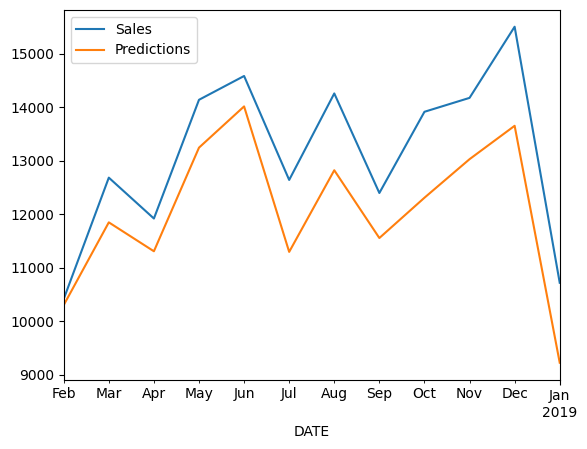

In [153]:
test.plot()

In [154]:
test

,Sales,Predictions
DATE,,
2018-02-01,10415,10300.718140
2018-03-01,12683,11847.192087
2018-04-01,11919,11306.644161
2018-05-01,14138,13243.688974
2018-06-01,14583,14014.538342
2018-07-01,12640,11295.205410
2018-08-01,14257,12821.074403
2018-09-01,12396,11554.478884
2018-10-01,13914,12307.679913
